In [1]:
## Setup

import numpy as np
import torch
from ml_collections.config_dict import ConfigDict
import os
import sys
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from utils.datasets import noisy_dataset_int, visualize_dataset
from utils.models import MultiHeadAttention, EncoderOnlyTransformers
from utils.optimization import mse_loss, cse_loss, check_accuracy
from tqdm import tqdm

import random
random.seed(0)

dtype = torch.float32

USE_GPU = True
if torch.cuda.is_available() and USE_GPU:
    device = 'cuda'
    torch.set_float32_matmul_precision('high')
elif torch.backends.mps.is_available() and USE_GPU:
    device = 'mps'
else:
    device = 'cpu'
print(f'Running on {device} device')

Running on mps device


/Users/darshil/miniconda3/envs/torch_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## Config

config = ConfigDict()

## data
config.p = 97
config.pair_seed = 1
config.frac = 0.5
config.noise_level = 0.0

## model
config.model_name = 'encoder'
config.n_layer = 1
config.act_name = 'relu'
config.s = 1.0 # s=1.0 for MuP, s=0.0 for SP
config.dropout = 0.0
config.if_ln = False # Use LayerNorm or Not
config.n_embd = 128
config.n_head = 4
config.wide_factor = 4 # MLP width
config.block_size = 2
config.vocab_size = config.p
config.mu = 1.0 # Skip Connections
config.dropout = 0.0
config.weight_tying = False # If use weight tying

## training
config.optim_name = 'adamw' # Only adamw and sgd
config.rescale_optim = False # Use this for Sho's NTP/MuP optimizer.
config.lr = 0.01
config.weight_decay = 0.5
config.beta1 = 0.9
config.beta2 = 0.98
config.eps = 1e-08
config.momentum = 0.9

config.steps = 1000
config.loss_type = 'cse'

In [3]:
## Dataset

dataset_dict = noisy_dataset_int(config.p, config.pair_seed, config.frac, config.noise_level, device, dtype)

X_train = dataset_dict['X_train']; Y_train = dataset_dict['Y_train']
X_test = dataset_dict['X_test']; Y_test = dataset_dict['Y_test']
X_og = dataset_dict['X_og']; Y_og = dataset_dict['Y_og']
total_size = Y_og.shape[0]

In [4]:
## Training

model = EncoderOnlyTransformers(MultiHeadAttention, config).to(device)
optimizer = model.config_optimizers(config)

train_losses = np.empty(config.steps)
test_losses = np.empty(config.steps)
train_accs = np.empty(config.steps)
test_accs = np.empty(config.steps)

loss_fn = mse_loss if config.loss_type == 'mse' else cse_loss
with tqdm(total = config.steps) as pbar:
    for t in tqdm(range(1, config.steps + 1, 1)):
        model.train()
        logits = model(X_train)[:, -1, :]
        loss = loss_fn(logits, Y_train, num_classes = config.p)
        train_acc = check_accuracy(logits, Y_train)

        optimizer.zero_grad(set_to_none = True)
        loss.backward()
        optimizer.step()

        with torch.inference_mode():
            model.eval()
            test_logits = model(X_test)[:, -1, :]
            test_loss = loss_fn(test_logits, Y_test, num_classes = config.p)
            test_acc = check_accuracy(test_logits, Y_test)
        
        train_losses[t-1] = loss.item()
        test_losses[t-1] = test_loss.item()
        train_accs[t-1] = train_acc.item()
        test_accs[t-1] = test_acc.item()
           
        pbar.set_description("Loss: {0:1.1e}|{1:1.1e}. Accuracy: {2:2.1f}%|{3:2.1f}%".format(
            loss.data,
            test_loss.data,
            train_acc * 100, 
            test_acc * 100))
        pbar.update(1)
        # print(f'Train Loss: {loss.data:.6f}, Test Loss: {test_loss.data:.6f}; Train Acc: {100 * tr_acc:.2f}, Test Acc: {100 * test_acc:.2f}')

0.209024 M non-embedding parameters


100%|██████████| 1000/1000 [00:17<00:00, 58.81it/s]%|█████████▉| 999/1000 [00:17<00:00, 58.33it/s]
Loss: 1.8e-05|9.9e-04. Accuracy: 100.0%|100.0%: 100%|██████████| 1000/1000 [00:17<00:00, 58.81it/s]


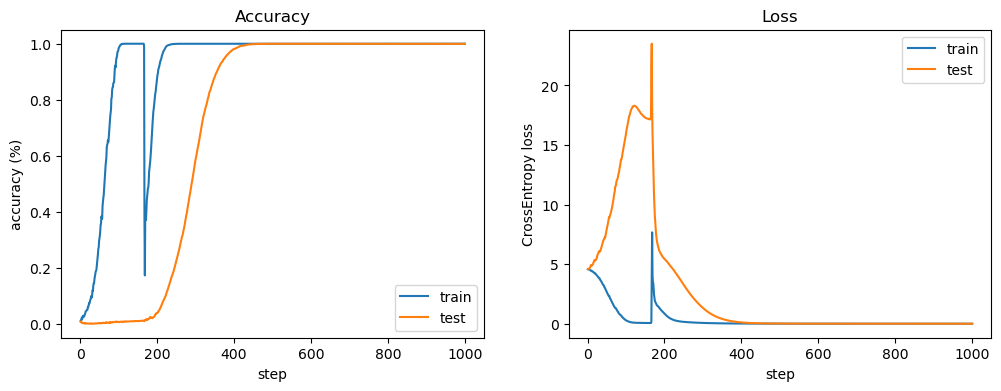

In [5]:
## Plot stuff

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.title('Accuracy')
plt.xlabel('step')
plt.ylabel('accuracy (%)')
plt.plot(np.arange(1, config.steps + 1, 1), train_accs, label='train')
plt.plot(np.arange(1, config.steps + 1, 1), test_accs, label='test')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.xlabel('step')
plt.ylabel('CrossEntropy loss')
plt.plot(np.arange(1, config.steps + 1, 1), train_losses, label='train')
plt.plot(np.arange(1, config.steps + 1, 1), test_losses, label='test')
plt.legend()

# plt.tight_layout()
plt.show()